In [1]:
!git clone https://github.com/kelvis24/new-simple-point-clouds.git

fatal: destination path 'new-simple-point-clouds' already exists and is not an empty directory.


In [2]:
pip install matplotlib

In [3]:
!pip install plyfile

In [4]:
pip install torch

In [5]:
pip install numpy torch trimesh open3d

In [6]:
!pip install rtree

In [7]:
import numpy as np
import torch
from plyfile import PlyData
import os

# Custom function to load point cloud data from binary .ply files
def load_point_cloud_from_ply(file_path):
    ply_data = PlyData.read(file_path)
    x = ply_data['vertex']['x']
    y = ply_data['vertex']['y']
    z = ply_data['vertex']['z']
    points = torch.tensor(np.column_stack((x, y, z)), dtype=torch.float32)
    return points

In [8]:
def resample_point_cloud(point_cloud, num_points):
    if len(point_cloud) == num_points:
        return point_cloud
    elif len(point_cloud) > num_points:
        indices = np.random.choice(len(point_cloud), size=num_points, replace=False)
        return point_cloud[indices]
    else:
        raise ValueError("Point cloud needs more points for resampling.")


In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to plot a single point cloud
def plot_point_cloud(points, title="Point Cloud", ax=None):
    if ax is None:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1)  # 's' is the size of each point
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    return ax

In [10]:
# Load all point clouds from the directory
point_clouds_directory = '/content/new-simple-point-clouds'
point_cloud_files = [f for f in os.listdir(point_clouds_directory) if f.endswith('.ply')]
point_clouds = [load_point_cloud_from_ply(os.path.join(point_clouds_directory, f)) for f in point_cloud_files]

# Find the number of points in the smallest point cloud
min_points = min(pc.shape[0] for pc in point_clouds)

# Resample all point clouds to match the smallest one
point_clouds = [resample_point_cloud(pc, min_points) for pc in point_clouds]

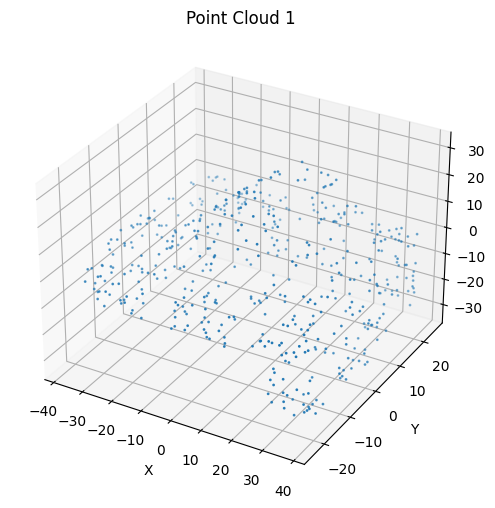

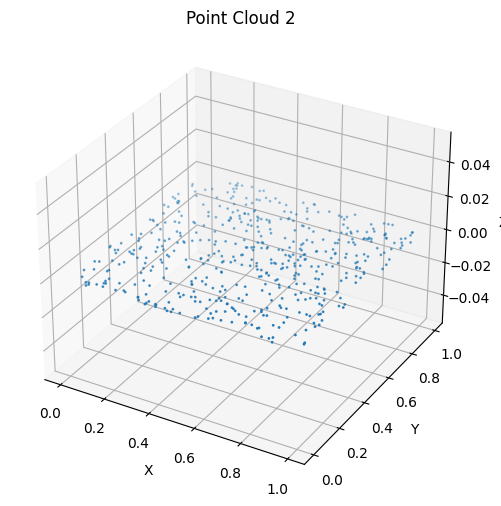

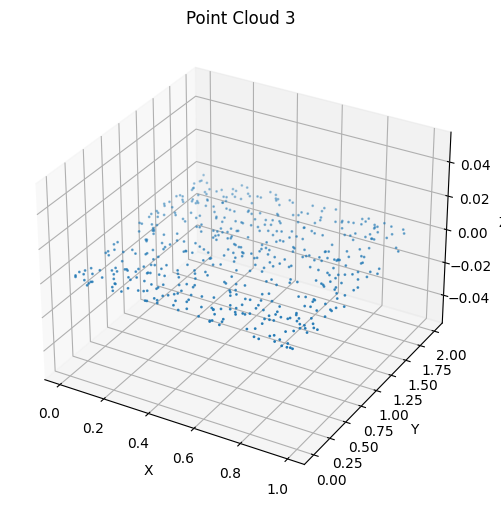

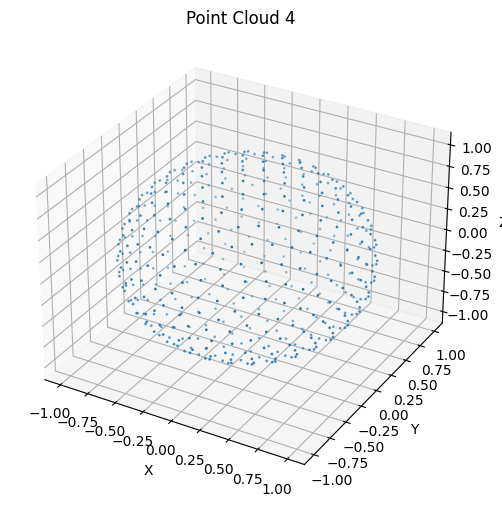

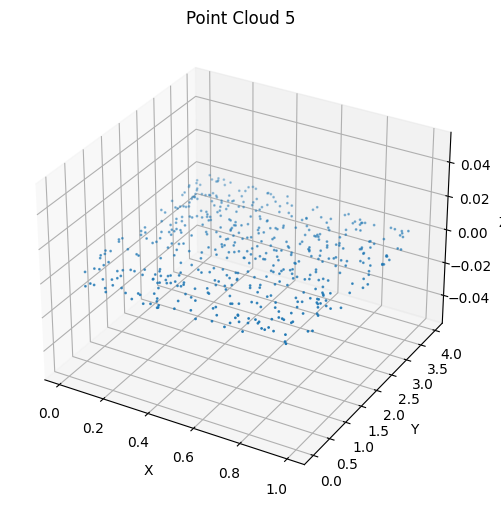

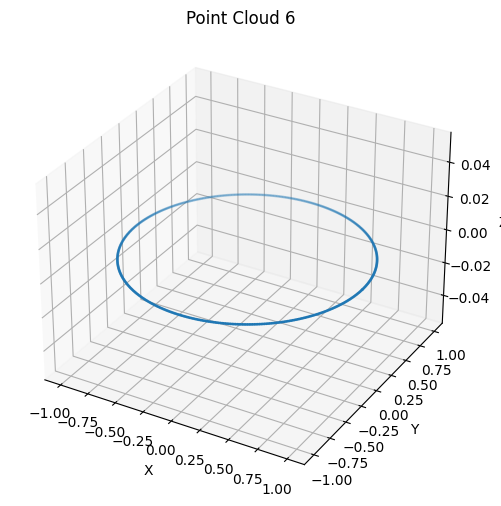

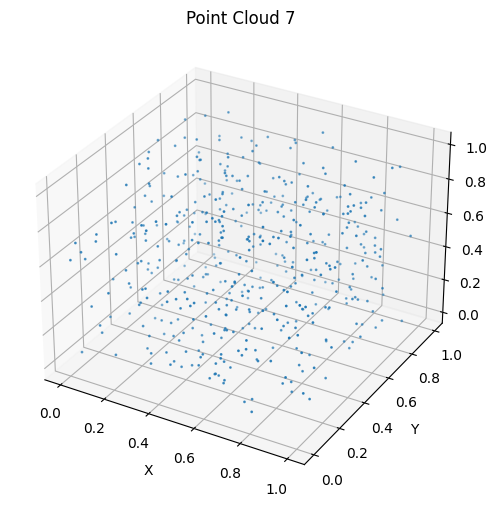

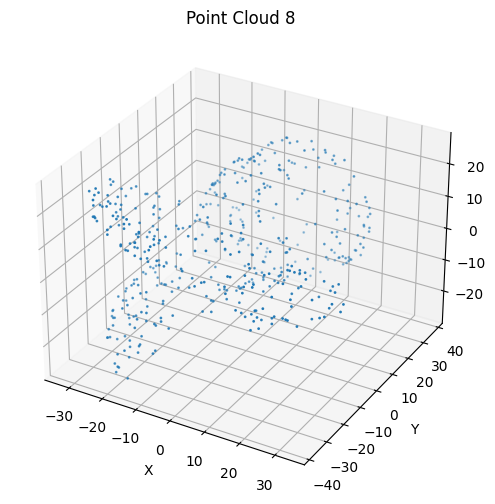

In [11]:
for i, point_cloud in enumerate(point_clouds):
    plot_point_cloud(point_cloud, title=f"Point Cloud {i + 1}")
    plt.show()

Epoch 1/50, Loss: 0.3343680799007416
Epoch 2/50, Loss: 0.32359182834625244
Epoch 3/50, Loss: 0.30543726682662964
Epoch 4/50, Loss: 0.27371618151664734
Epoch 5/50, Loss: 0.22515393793582916
Epoch 6/50, Loss: 0.162875697016716
Epoch 7/50, Loss: 0.1092618927359581
Epoch 8/50, Loss: 0.10887345671653748
Epoch 9/50, Loss: 0.08545960485935211
Epoch 10/50, Loss: 0.04467066004872322
Epoch 11/50, Loss: 0.022278770804405212
Epoch 12/50, Loss: 0.018920090049505234
Epoch 13/50, Loss: 0.020474115386605263
Epoch 14/50, Loss: 0.019011102616786957
Epoch 15/50, Loss: 0.015061886981129646
Epoch 16/50, Loss: 0.012977770529687405
Epoch 17/50, Loss: 0.015348635613918304
Epoch 18/50, Loss: 0.018271496519446373
Epoch 19/50, Loss: 0.016631437465548515
Epoch 20/50, Loss: 0.012364977970719337
Epoch 21/50, Loss: 0.009885046631097794
Epoch 22/50, Loss: 0.009988353587687016
Epoch 23/50, Loss: 0.01042506005614996
Epoch 24/50, Loss: 0.00938570685684681
Epoch 25/50, Loss: 0.007127756718546152
Epoch 26/50, Loss: 0.0053

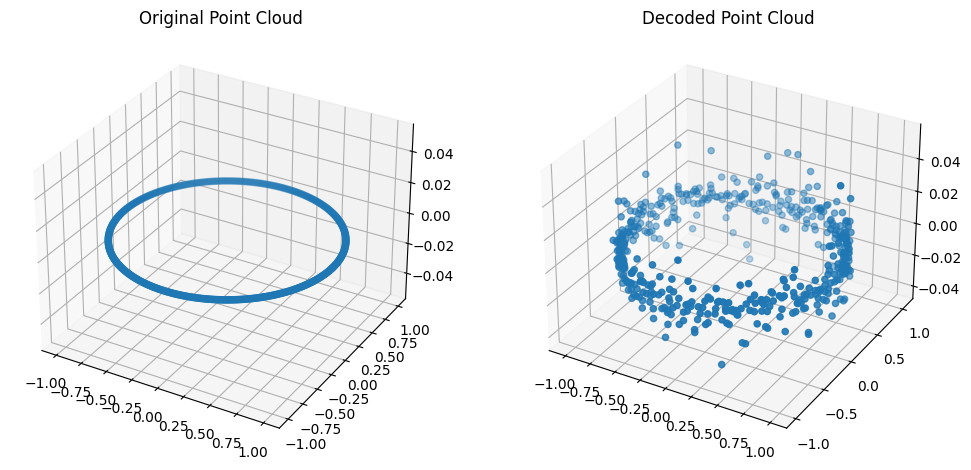

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# PointNet Components without Batch Normalization
class PointNetEncoder(nn.Module):
    def __init__(self, global_feat=True, feature_transform=False):
        super(PointNetEncoder, self).__init__()
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.global_feat = global_feat
        self.feature_transform = feature_transform

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        x = torch.max(x, 2, keepdim=False)[0]
        return x

class PointNetDecoder(nn.Module):
    def __init__(self, num_points=2048):
        super(PointNetDecoder, self).__init__()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_points * 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x.view(-1, 3)  # Adjusted for single point cloud without batch dimension

# Autoencoder combining both
class PointNetAutoencoder(nn.Module):
    def __init__(self, num_points=2048):
        super(PointNetAutoencoder, self).__init__()
        self.encoder = PointNetEncoder()
        self.decoder = PointNetDecoder(num_points=num_points)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Visualization function remains the same
def plot_point_clouds(original, decoded, title1="Original Point Cloud", title2="Decoded Point Cloud"):
    fig = plt.figure(figsize=(12, 6))

    # Original Point Cloud
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(original[:, 0], original[:, 1], original[:, 2])
    ax1.set_title(title1)

    # Decoded Point Cloud
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(decoded[:, 0], decoded[:, 1], decoded[:, 2])
    ax2.set_title(title2)

    plt.show()


def train_autoencoder(point_cloud_data, epochs=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Adjusted to handle point cloud data as a single instance
    point_cloud_data = point_cloud_data.to(device).unsqueeze(0).permute(0, 2, 1)  # Shape [1, 3, num_points]

    num_points = point_cloud_data.shape[-1]

    model = PointNetAutoencoder(num_points=num_points).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(point_cloud_data)
        loss = criterion(output, point_cloud_data.squeeze().permute(1, 0))  # Adjusted loss calculation
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

    # Visualizing the result
    with torch.no_grad():
        decoded_pc = model(point_cloud_data).view(num_points, 3)
        plot_point_clouds(point_cloud_data, decoded_pc.cpu().numpy())


# Assuming point_cloud_data is a [num_points, 3] tensor
# Load your point cloud here
point_cloud_data = point_clouds[5]  # Example data, replace with your actual point cloud data

# Adjust the call to the training function as needed
train_autoencoder(point_cloud_data)


Epoch 1/50, Loss: 0.3360612094402313
Epoch 2/50, Loss: 0.3249972462654114
Epoch 3/50, Loss: 0.3061889708042145
Epoch 4/50, Loss: 0.27281057834625244
Epoch 5/50, Loss: 0.22232820093631744
Epoch 6/50, Loss: 0.16179658472537994
Epoch 7/50, Loss: 0.12565185129642487
Epoch 8/50, Loss: 0.12489043176174164
Epoch 9/50, Loss: 0.0837605893611908
Epoch 10/50, Loss: 0.046579644083976746
Epoch 11/50, Loss: 0.03289002552628517
Epoch 12/50, Loss: 0.029794840142130852
Epoch 13/50, Loss: 0.025304483249783516
Epoch 14/50, Loss: 0.018686605617403984
Epoch 15/50, Loss: 0.01518511027097702
Epoch 16/50, Loss: 0.01748497411608696
Epoch 17/50, Loss: 0.019415585324168205
Epoch 18/50, Loss: 0.01583961397409439
Epoch 19/50, Loss: 0.011199722066521645
Epoch 20/50, Loss: 0.010002112947404385
Epoch 21/50, Loss: 0.010891753248870373
Epoch 22/50, Loss: 0.010735111311078072
Epoch 23/50, Loss: 0.00868628267198801
Epoch 24/50, Loss: 0.00643092580139637
Epoch 25/50, Loss: 0.005913794040679932
Epoch 26/50, Loss: 0.0066167

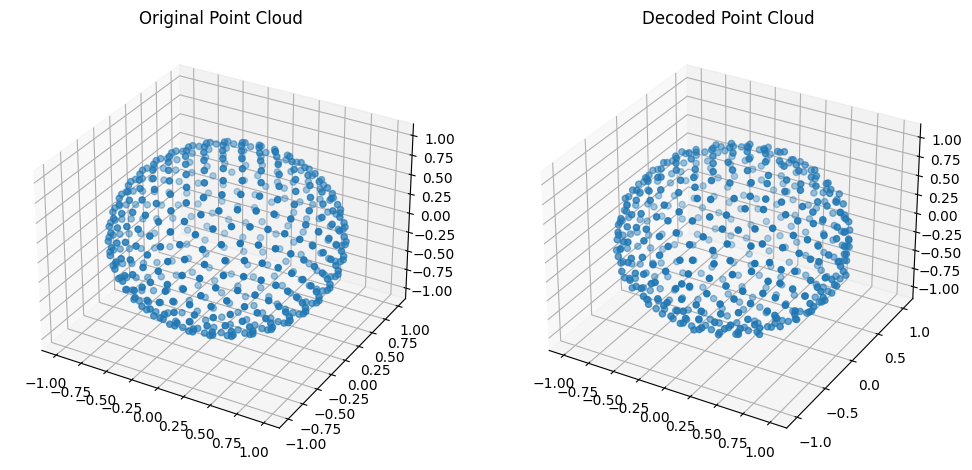

In [13]:

# Assuming point_cloud_data is a [num_points, 3] tensor
# Load your point cloud here
point_cloud_data = point_clouds[3]  # Example data, replace with your actual point cloud data

# Adjust the call to the training function as needed
train_autoencoder(point_cloud_data)